In [84]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

### Simple Siamese Network

In [46]:
num_classes = 10
epochs = 20


#### Euclidean Distance

In [47]:

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

#### Loss Function

In [48]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


#### Preparing data

In [49]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


In [50]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

In [51]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
train_pairs, train_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
test_pairs, test_y = create_pairs(x_test, digit_indices)


#### Creating Network

In [52]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_data = Input(shape=input_shape)
    x = Flatten()(input_data)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input_data, x)

In [53]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
emb_a = base_network(input_a)
emb_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([emb_a, emb_b])

model = Model([input_a, input_b], distance)

In [54]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 128)          133504      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model_3[1][0]              

In [56]:

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)



In [57]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [58]:
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

In [63]:
model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/20
847/847 [==============================] - 9s 11ms/step - loss: 0.0984 - accuracy: 0.8832 - val_loss: 0.0432 - val_accuracy: 0.9519
Epoch 2/20
847/847 [==============================] - 7s 9ms/step - loss: 0.0415 - accuracy: 0.9573 - val_loss: 0.0304 - val_accuracy: 0.9654
Epoch 3/20
847/847 [==============================] - 7s 9ms/step - loss: 0.0289 - accuracy: 0.9707 - val_loss: 0.0269 - val_accuracy: 0.9709
Epoch 4/20
847/847 [==============================] - 7s 8ms/step - loss: 0.0228 - accuracy: 0.9762 - val_loss: 0.0265 - val_accuracy: 0.9718
Epoch 5/20
847/847 [==============================] - 7s 8ms/step - loss: 0.0194 - accuracy: 0.9798 - val_loss: 0.0247 - val_accuracy: 0.9718
Epoch 6/20
847/847 [==============================] - 6s 7ms/step - loss: 0.0171 - accuracy: 0.9821 - val_loss: 0.0258 - val_accuracy: 0.9715
Epoch 7/20
847/847 [==============================] - 6s 7ms/step - loss: 0.0157 - accuracy: 0.9835 - val_loss: 0.0251 - val_accuracy: 0.9724
Epoch

In [64]:

# compute final accuracy on training and test sets
y_pred = model.predict([train_pairs[:, 0], train_pairs[:, 1]])
tr_acc = compute_accuracy(train_y, y_pred)
y_pred = model.predict([test_pairs[:, 0], test_pairs[:, 1]])
te_acc = compute_accuracy(test_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.49%
* Accuracy on test set: 97.10%


In [65]:
model.save("mnist_simple_siamese")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: mnist_simple_siamese/assets


In [66]:
model.save("mnist_simple_siamese.h5")

In [96]:
test_pairs1 = test_pairs[1, 0].reshape(1, 28, 28, 1)
test_pairs2 = test_pairs[1, 1].reshape(1, 28, 28, 1)

In [97]:
pred = model.predict([test_pairs1, test_pairs2])

First Digit


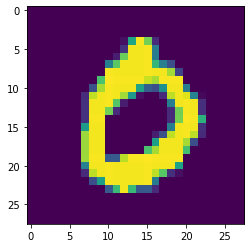

In [109]:
print("First Digit")
plt.imshow(test_pairs[1, 0])

The second digit is


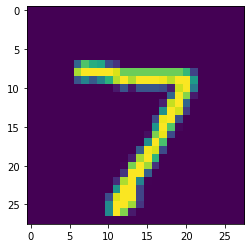

In [110]:
print("The second digit is")
plt.imshow(test_pairs[1, 1])

In [111]:
print("The euclidean distance between two digits are ", pred[0][0])

The euclidean distance between two digits are  1.3601397
